In [1]:
import csv
import os
import numpy as np
import tensorflow as tf

In [2]:
train_data = 'data_set/data/train/train.csv'
val_data = 'data_set/data/val/val.csv'
test_data = 'data_set/data/test/test.csv'
model_save_path = 'keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier.tflite'

In [3]:
NUM_CLASSES = 0
for item in os.listdir("data_set/data/train/"):
    NUM_CLASSES += 1
# -1 to remove train.csv
NUM_CLASSES -= 1 
print(NUM_CLASSES)

4


In [4]:
x_train = np.loadtxt(train_data, delimiter=',', dtype='float32', usecols=list(range(2, (21 * 2) + 2)))
y_train = np.loadtxt(train_data, delimiter=',', dtype='int32', usecols=(1))

In [5]:
x_val = np.loadtxt(val_data, delimiter=',', dtype='float32', usecols=list(range(2, (21 * 2) + 2)))
y_val = np.loadtxt(val_data, delimiter=',', dtype='int32', usecols=(1))

In [6]:
x_test = np.loadtxt(test_data, delimiter=',', dtype='float32', usecols=list(range(2, (21 * 2) + 2)))
y_test = np.loadtxt(test_data, delimiter=',', dtype='int32', usecols=(1))

In [7]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input((21 * 2, )),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(20, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(10, activation='relu'),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])

In [8]:
input_shape = (42,)
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(input_shape + (1,), input_shape=input_shape),
    tf.keras.layers.Conv1D(6, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(16, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [9]:
model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 42, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 38, 6)             36        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 6)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 16)            496       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 112)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               1

In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=5,
    validation_data=(x_val, y_val),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
405/409 [============================>.] - ETA: 0s - loss: 0.3686 - accuracy: 0.8731
Epoch 00001: saving model to keypoint_classifier.hdf5
409/409 [==============================] - 3s 8ms/step - loss: 0.3653 - accuracy: 0.8743 - val_loss: 0.0776 - val_accuracy: 0.9758
Epoch 2/1000
394/409 [===========================>..] - ETA: 0s - loss: 0.0645 - accuracy: 0.9858
Epoch 00002: saving model to keypoint_classifier.hdf5
409/409 [==============================] - 2s 5ms/step - loss: 0.0657 - accuracy: 0.9853 - val_loss: 0.0356 - val_accuracy: 0.9831
Epoch 3/1000
405/409 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9901
Epoch 00003: saving model to keypoint_classifier.hdf5
409/409 [==============================] - 2s 6ms/step - loss: 0.0492 - accuracy: 0.9897 - val_loss: 0.0268 - val_accuracy: 0.9928
Epoch 4/1000
398/409 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9905
Epoch 00004: saving model to keypoint_classifier.hdf5

In [13]:
# Model evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=5)

43/43 [==============================] - 0s 3ms/step - loss: 0.0789 - accuracy: 0.9953


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

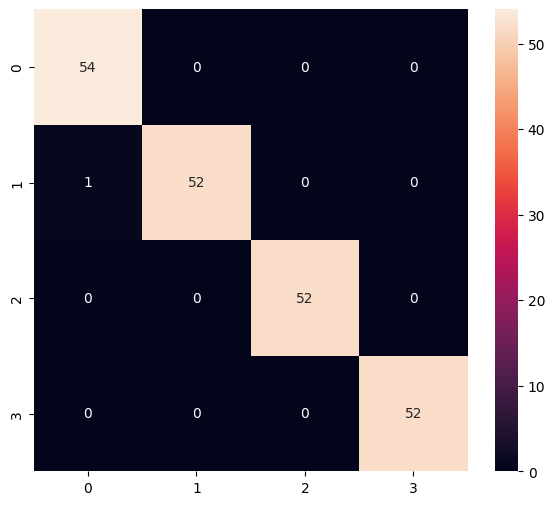

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.98      0.99        53
           2       1.00      1.00      1.00        52
           3       1.00      1.00      1.00        52

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\TRUNGH~1\AppData\Local\Temp\tmpd8grik71\assets


34688